### A quick and dirty LandSAT validation test

In this notebook we extract a subset of Australian tree cover from LandSAT data, and do a quick and dirty validation exercise with coincident LiDAR.

The point of this exercise is to test and demonstrate data service models, *not* to perform an accurate validation.

In [9]:
# import python things - we will need:

#OS interaction (maybe)
import os

#postgres 
import psycopg2 as ppg

#numpy
import numpy as np

#osgeo libraries
from osgeo import ogr

#possibly - shapely for tinkering with geometries
import shapely as sp
from shapely.geometry import Point,Polygon,asShape
from shapely.wkt import loads as wkt_loads
from shapely import speedups

#maybe cartopy, but I'm not sure
#import cartopy as cp
#import cartopy.crs as ccrs

#geopandas - very neat for pulling up postGIS geometries
import geopandas as gp

#matplotlib of course!
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

#set up for 3d plots
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pylab as pylab

#fiona and descartes
import fiona
from descartes import PolygonPatch

#OWSlib, so we can get web coverages etc.
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService


import numpy as np
from netCDF4 import Dataset
import pandas as pd


### 1. Define a region and select some LandSAT data. 

We know our LIDAR data only cover a small region:


...and were collected in 2013 - so we'll grab coincident LandSAT data from the same year and the same region using a web service request

In [10]:
f = Dataset('http://dapds00.nci.org.au/thredds/dodsC/ub8/au/treecover/ANUWALD.TreeCover.25m.2015.nc')

In [11]:
#don't need to pull any actual data down yet - lets see what is in this file.
for key in f.variables.keys():
    print(f.variables[key])

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    long_name: time
    units: days since 1800-01-01 0:0:0
unlimited dimensions: 
current shape = (1,)
filling off

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    long_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (136000,)
filling off

<class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    long_name: longitude
    units: degrees_east
unlimited dimensions: 
current shape = (168000,)
filling off

<class 'netCDF4._netCDF4.Variable'>
int8 TreeCover(time, longitude, latitude)
    _Unsigned: false
    _FillValue: -99
    _ChunkSizes: [   1 2275 1842]
unlimited dimensions: 
current shape = (1, 168000, 136000)
filling off



In [12]:
lon = f.variables['longitude'][:]
lat = f.variables['latitude'][:]

In [13]:
##so lets find a Canberra-ish region
region = [134,136, -38, -36]
lon_si = np.squeeze(np.where((lon >= region[0]) & (lon <= region[1])))
lat_si = np.squeeze(np.where((lat >= region[2]) & (lat <= region[3])))
lat[lat_si[0]]

-36.000126

In [35]:
(min(lon_si),max(lon_si))

(88000, 95999)

In [36]:
lon_si.shape

(8000,)

In [29]:
##and harvest the region from the netCDF file
# can we directly use lon and lat on the GVC array? hmm
# No, but we don't have to get the array before indexing into it.. we just get the subset!
#treecover = f.variables['TreeCover'][min(lon_si[0]): max(lon_si[0]), min(lat_si[0]): max(lat_si[0])]

treecover = f.variables['TreeCover'][0,110000:129999,92000:111999]

In [30]:
tree_cover = treecover[0]

In [31]:
tree_cover = np.ma.filled(tree_cover, -999)

In [37]:
tree_cover.shape

(19999,)

In [50]:
tree_cover = np.ma.filled(treecover)

In [51]:
tree_cover

array([[  0,   0,   0, ..., -99, -99, -99],
       [  0,   0,   0, ..., -99, -99, -99],
       [  0,   0,   0, ..., -99, -99, -99],
       ..., 
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int8)

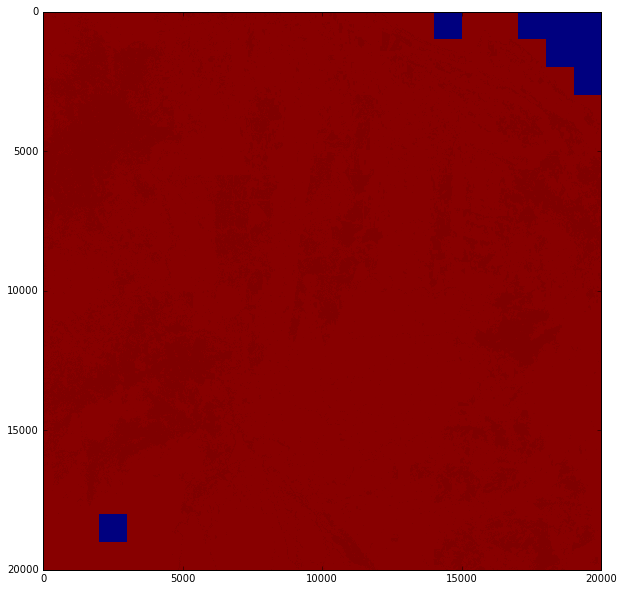

In [59]:
from cartopy import config
import cartopy.crs as ccrs
# Plot. 
fig = plt.figure(figsize=(10, 10))

plt.imshow(tree_cover)

In [70]:
this = np.where((tree_cover > 0) & (tree_cover <= 1))

In [71]:
np.shape(tree_cover)

(19999, 19999)

TypeError: Invalid dimensions for image data

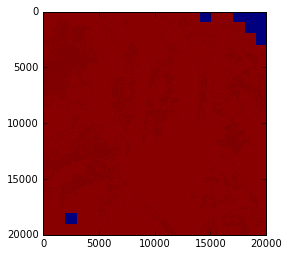